<h1><center>CANDIES tutorial for simulated multi-omics data</center></h1>

## Read in data

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import warnings

# read data
file_fold = 'E:/yan0/ours/CANDIES/data/simulation' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'simulated_data_rna.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'simulated_data_adt.h5ad')

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
D:\anaconda3\envs\my\Lib\site-packages\anndata\utils.py:429: FutureWarning: Importing read_mtx from `anndata` is deprecated. Import anndata.io.read_mtx instead.
  warnings.warn(msg, FutureWarning)
D:\anacon

In [2]:
adata_omics1

AnnData object with n_obs × n_vars = 1296 × 800
    obs: 'ground_truth'
    uns: 'log1p'
    obsm: 'nsfac', 'spatial', 'spfac'
    varm: 'nsload', 'spload'
    layers: 'counts'

In [3]:
adata_omics2

AnnData object with n_obs × n_vars = 1296 × 200
    obs: 'ground_truth'
    uns: 'log1p'
    obsm: 'nsfac', 'spatial', 'spfac'
    varm: 'nsload', 'spload'
    layers: 'counts'

In [4]:
import numpy as np

mean = 2
std_dev = 3.5

noise2 = np.random.normal(loc=mean, scale=std_dev, size=adata_omics2.X.shape)

adata_omics2.X = adata_omics2.X + noise2

In [5]:
mean = 2
std_dev = 4

noise1 = np.random.normal(loc=mean, scale=std_dev, size=adata_omics1.X.shape)

adata_omics1.X = adata_omics1.X + noise1

In [20]:
def run_leiden(adata1, n_cluster, use_rep="embeddings", key_added="Nleiden", range_min=0, range_max=3, max_steps=30, tolerance=0):
    adata = adata1.copy()
    sc.pp.neighbors(adata, use_rep=use_rep)
    this_step = 0
    this_min = float(range_min)
    this_max = float(range_max)
    while this_step < max_steps:
        this_resolution = this_min + ((this_max-this_min)/2)
        sc.tl.leiden(adata, resolution=this_resolution)
        this_clusters = adata.obs['leiden'].nunique()

        if this_clusters > n_cluster+tolerance:
            this_max = this_resolution
        elif this_clusters < n_cluster-tolerance:
            this_min = this_resolution
        else:
            print("Succeed to find %d clusters at resolution %.3f"%(n_cluster, this_resolution))
            adata1.obs[key_added] = adata.obs["leiden"]
            
            return adata1
        
        this_step += 1
    
    adata1.obs[key_added] = adata.obs["leiden"]
    return adata1

In [7]:
from codes.DiTs import *
from codes.sampler import *
from codes.train_diff import *
from codes.ZINB_encoder import *
from codes.preprocess1 import *

E:\yan0\ours\CANDIES_code\tutorial
NVIDIA GeForce RTX 4060


## Data preprocessing

In [8]:
# RNA
sc.pp.filter_genes(adata_omics1, min_cells=50)
sc.pp.filter_genes(adata_omics1, min_counts=10)
sc.pp.normalize_total(adata_omics1, target_sum=1e6)
sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=2000)
sc.pp.scale(adata_omics1)

adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=adata_omics2.n_vars-1)

# Protein
sc.pp.scale(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars-1)

## Encoding phase

In [9]:
from codes.get_graph import construct_neighbor_graph,adjacent_matrix_preprocessing
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

adata_omics1, adata_omics2 = construct_neighbor_graph(adata_omics1, adata_omics2)

adj = adjacent_matrix_preprocessing(adata_omics1, adata_omics2)
adj_spatial_omics1 = adj['adj_spatial_omics1'].to(device)
adj_spatial_omics2 = adj['adj_spatial_omics2'].to(device)

In [17]:
ae_model = encoder_ZINB(
    adata=adata_omics1,
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    epochs=300, 
    dim_output=256, # 256
)

adata_omics1.obsm['emb_ZINB'], adj_mat = ae_model.train()

 37%|███▋      | 110/300 [00:00<00:00, 298.89it/s]

Early stop!
Optimization finished


In [11]:
seed = 2024
seed_everything(seed)

from codes.AutoEncoder import train_model
train_model(adata_omics1, adata_omics2, adj_spatial_omics1, adj_spatial_omics2, epochs=1000)

Epoch [100/1000], Loss RNA: 0.8573, Loss Protein: 0.7355
Epoch [200/1000], Loss RNA: 0.7944, Loss Protein: 0.6529
Epoch [300/1000], Loss RNA: 0.7725, Loss Protein: 0.6221
Epoch [400/1000], Loss RNA: 0.7631, Loss Protein: 0.6067
Epoch [500/1000], Loss RNA: 0.7568, Loss Protein: 0.5932
Epoch [600/1000], Loss RNA: 0.7518, Loss Protein: 0.5828
Epoch [700/1000], Loss RNA: 0.7474, Loss Protein: 0.5748
Epoch [800/1000], Loss RNA: 0.7462, Loss Protein: 0.5680
Epoch [900/1000], Loss RNA: 0.7444, Loss Protein: 0.5623
Epoch [1000/1000], Loss RNA: 0.7417, Loss Protein: 0.5563
Training complete!
Latent representations have been successfully added to adata_omics.obsm!


In [21]:
adata_omics1 = run_leiden(adata_omics1, n_cluster=5, use_rep="emb_ZINB", key_added="AE")

In [22]:
adata_omics2 = run_leiden(adata_omics2, n_cluster=5, use_rep="emb_latent_omics2", key_added="AE")

Succeed to find 5 clusters at resolution 0.750


## Modality selcetion
The modality selcetion of CANDIES requires following input data: 
<br>
1. With annotation: cluster results of the two modality after encoding phase, and the annotation labels.
<br>
2. Without annotation: cluster results and the embeddings of the two modality after encoding phase.
<br>


In [54]:
from codes.modality_selection import modality_selection
modality_selection(adata_omics1.obs['AE'],adata_omics2.obs['AE'],ground_truth=adata_omics2.obs['ground_truth'])

We recommend you use modality 2 as condition in the denoise phase!


## Denoise phase
Before the diffusion process, we need to align the two modality embeddings according to the spatial coordinates.

In [24]:
slices_omics1_spatial = adata_omics1.obsm['spatial']
slices_omics2_spatial = adata_omics2.obsm['spatial']

emb_latent_omics1 = adata_omics1.obsm['emb_ZINB']

emb_latent_omics2 = adata_omics2.obsm['emb_latent_omics2']

import pandas as pd

df_omics1 = pd.DataFrame(emb_latent_omics1, index=[tuple(coord) for coord in slices_omics1_spatial])
df_omics2 = pd.DataFrame(emb_latent_omics2, index=[tuple(coord) for coord in slices_omics2_spatial])

df_omics2_aligned = df_omics2.reindex(df_omics1.index)

aligned_emb_latent_omics1 = df_omics1.to_numpy()
aligned_emb_latent_omics2 = df_omics2_aligned.to_numpy()

print(aligned_emb_latent_omics1.shape)
print(aligned_emb_latent_omics2.shape)

(1296, 256)
(1296, 64)


In [25]:
class ConditionalDiffusionDataset():
    def __init__(self, adata_omics1, adata_omics2):
        self.adata_omics1 = adata_omics1
        self.adata_omics2 = adata_omics2

        self.st_sample = torch.tensor(self.adata_omics1, dtype=torch.float32)
        self.con_sample = torch.tensor(self.adata_omics2, dtype=torch.float32)
        self.con_data = torch.tensor(self.adata_omics2, dtype=torch.float32)

    def __len__(self):
        return len(self.adata_omics1)

    def __getitem__(self, idx):
        return self.st_sample[idx], self.con_sample[idx], self.con_data

In [26]:
dataset = ConditionalDiffusionDataset(aligned_emb_latent_omics1, aligned_emb_latent_omics2) # denoise the first modality, condition on the second modality.

seed = 2024
seed_everything(seed)

com_mtx = run_diff(
    dataset,

    k=3,
    batch_size=512,
    hidden_size=512,
    learning_rate=1e-3,

    num_epoch=1000,
    diffusion_step=800,

    depth=6,
    head=16,

    device='cuda:0',
    classes=6,  
    patience=30,
    bias=1 
)

*******************  Fold 1  (total 3 folds)  ********************


 30%|███████▍                 | 297/1000 [01:25<03:22,  3.47it/s, noise loss:0.0426229, lr:1.00e-05]


Early stop(patience:30)!!


time: 0: 100%|██████████| 800/800 [01:15<00:00, 10.58it/s]  


*******************  Fold 2  (total 3 folds)  ********************


 30%|███████▍                 | 299/1000 [01:29<03:29,  3.35it/s, noise loss:0.0320037, lr:1.00e-06]


Early stop(patience:30)!!


time: 0: 100%|██████████| 800/800 [00:50<00:00, 15.74it/s]  


*******************  Fold 3  (total 3 folds)  ********************


 30%|███████▌                 | 300/1000 [01:26<03:21,  3.47it/s, noise loss:0.0307454, lr:1.00e-06]


Early stop(patience:30)!!


time: 0: 100%|██████████| 800/800 [00:50<00:00, 15.86it/s]  


In [27]:
adata_omics1.obsm['denoise_emb'] = com_mtx

In [28]:
from codes.preprocess1 import clustering

tool = 'mclust' # mclust, leiden, and louvain
clustering(adata_omics1, key='denoise_emb', add_key='Denoise', n_clusters=5, end=1.2, method=tool, use_pca=True)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.1.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [29]:
ground_truth = adata_omics1.obs['ground_truth']
denoise = adata_omics1.obs['Denoise']

ari_score_denoise = adjusted_rand_score(ground_truth, denoise)
ari_score_denoise

0.9080550573216377

## Integration phase

In [30]:
from codes.integration import *

In [31]:
adata1 = adata_omics1.copy()
adata2 = adata_omics2.copy()

In [33]:
data_type = '10x'
adata1.obsm['feat'] = adata1.obsm['denoise_emb']
adata2.obsm['feat'] = adata2.obsm['emb_latent_omics2']
adata1, adata2 = construct_neighbor_graph(adata1, adata2)

In [34]:
adj = adjacent_matrix_preprocessing(adata1, adata2)
adj_spatial_omics1 = adj['adj_spatial_omics1'].to(device)
adj_spatial_omics2 = adj['adj_spatial_omics2'].to(device)
adj_feature_omics1 = adj['adj_feature_omics1'].to(device)
adj_feature_omics2 = adj['adj_feature_omics2'].to(device)

In [44]:
features_omics1 = torch.FloatTensor(adata1.obsm['feat'].copy()).to(device)
features_omics2 = torch.FloatTensor(adata2.obsm['feat'].copy()).to(device)

seed = 2025
seed_everything(seed)

result = train_and_infer(
    features_omics1=features_omics1,
    features_omics2=features_omics2,
    adj_spatial_omics1=adj_spatial_omics1,
    adj_feature_omics1=adj_feature_omics1,
    adj_spatial_omics2=adj_spatial_omics2,
    adj_feature_omics2=adj_feature_omics2,
    device=device,
    epochs=200
)

Training Progress: 100%|██████████| 200/200 [00:26<00:00,  7.62it/s, Total Loss=9.28, Contrastive Loss (Spatial)=2.23, Contrastive Loss (Feature)=4.34, Reconstruction Loss 1=0.253, Reconstruction Loss 2=1.1, Reconstruction Loss 3=0.246, Reconstruction Loss 4=1.12] 


In [45]:
adata = adata1.copy()
adata.obsm['CANDIES'] = result['emb_latent_combined'].detach().cpu().numpy().copy()

## Visualization

In [46]:
clustering(adata, key='CANDIES', add_key='CANDIES', n_clusters=5, end=1, method=tool, use_pca=True)

fitting ...
  |======================================================================| 100%


In [47]:
sc.pp.neighbors(adata, use_rep='CANDIES', n_neighbors=10)
sc.tl.umap(adata)

In [48]:
from sklearn.metrics import adjusted_rand_score

# 提取 ground_truth 和 AE 列
ground_truth = adata.obs['ground_truth']
CANDIES = adata.obs['CANDIES']

# 计算 ARI
ari_score_CANDIES = adjusted_rand_score(ground_truth, CANDIES)

print(f"Adjusted Rand Index (ARI) between ground_truth and AE: {ari_score_CANDIES:.4f}")

Adjusted Rand Index (ARI) between ground_truth and AE: 0.9781


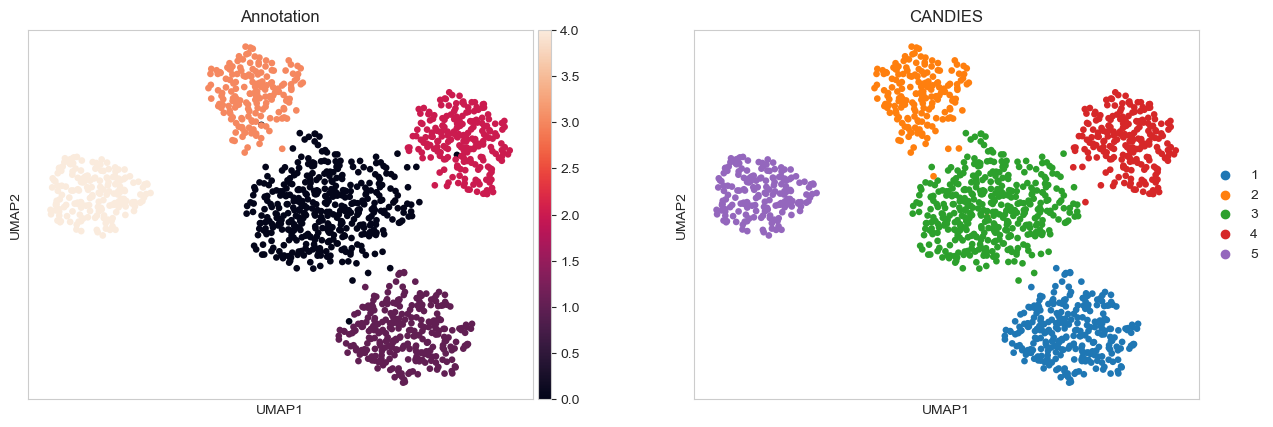

In [50]:
sc.pl.umap(adata, color=["ground_truth", "CANDIES"], wspace=0.2,title=["Annotation", "CANDIES"])

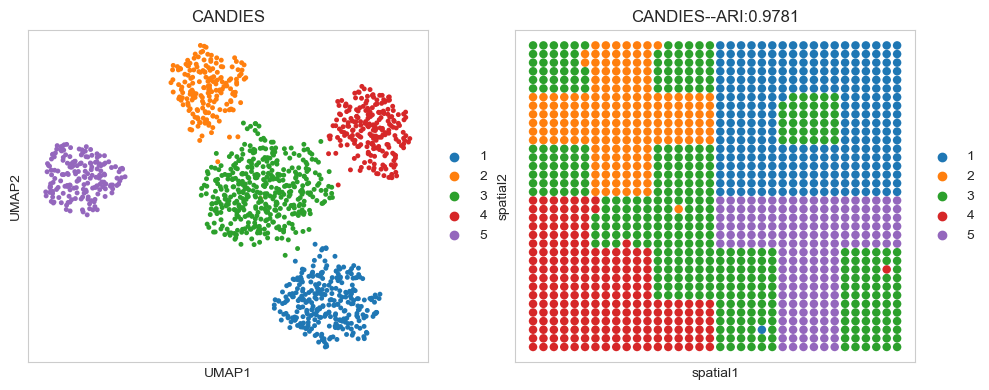

In [53]:
# visualization
import matplotlib.pyplot as plt

fig, ax_list = plt.subplots(1, 2, figsize=(10, 4))

sc.pl.umap(adata, color='CANDIES', ax=ax_list[0], title='CANDIES', s=50, show=False)
sc.pl.embedding(adata, basis='spatial', color='CANDIES', ax=ax_list[1],
                title=f'CANDIES--ARI:{ari_score_CANDIES:.4f}', s=150, show=False)

plt.tight_layout(w_pad=0.3)
plt.show()